# Introduction

### Description and Background

Toronto is the provincial capital of Ontario and the most populous city in Canada, with a population of 2,731,571 in 2016. Toronto is the fastest growing city in North America. Toronto is an international centre of business, finance, arts, and culture, and is recognized as one of the most multicultural and cosmopolitan cities in the world.The city proper has since expanded past its original borders through both annexation and amalgamation to its current area of 630.2 km2 (243.3 sq mi).<br>

### Problem

As we can see there is lot of opportunities for business in this city, I would like to create a report to understand which business should be setup in which part of the city so that their business should florish.<br>
For example if you open a retaurant in a place which is more popular among the people because of local GYM or any fitness centre then our restaurant may not be that much of success then the place where we already have different restaurants in the area. Bcause people would try to look for new and better option if we are going to open an restaurant in an area where one restaurant is already present. Or you can say people may want to try out new GYM eqipments provided by new gym centre and their services rather than if place a GYM in an area which is popular among foody kind of people looking for new food items.

# Data

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
# define the dataframe columns
column_names = ['PostalCode', 'Borough', 'Neighborhood'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [3]:
from bs4 import BeautifulSoup
import requests

In [4]:
web_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(web_url,'lxml')
table = soup.find('table',{'class':'wikitable sortable'})
df = pd.read_html(str(table), header=0)[0]

df.drop(df.loc[df['Borough']=='Not assigned'].index, inplace=True)
df = df.groupby(['Postcode','Borough'])['Neighbourhood'].apply(', '.join).reset_index()
df.rename(columns={"Postcode": "PostalCode", "Neighbourhood": "Neighborhood"}, inplace=True)
neighborhoods = df

for index, row in neighborhoods.iterrows():
     # access data using column names
     if (row['Neighborhood'] == 'Not assigned'):
         row['Neighborhood'] = row['Borough']

neighborhoods.shape

(103, 3)

In [5]:
neighborhoods['Borough'].unique()

array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'Central Toronto', 'Downtown Toronto', 'York', 'West Toronto',
       "Queen's Park", 'Mississauga', 'Etobicoke'], dtype=object)

In [6]:
df_lat_lng = pd.read_csv("http://cocl.us/Geospatial_data", header=0)
df_lat_lng.head()
df_lat_lng.rename(columns={"Postal Code": "PostalCode"}, inplace=True)
neighbor_geo = pd.merge(left=neighborhoods,right=df_lat_lng, left_on='PostalCode', right_on='PostalCode')
neighbor_geo.head()


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [7]:
# coordinates for toronto
latitude = 43.6532
longitude = -79.3832

In [8]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighbor_geo['Latitude'], neighbor_geo['Longitude'], neighbor_geo['Borough'], neighbor_geo['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [9]:
CLIENT_ID = 'ZDTA14FHN0UMDZZCHOWGCQHKWOSCMMLYG5A4EPQVMWLPCKQR' # your Foursquare ID
CLIENT_SECRET = '15A1TKSY5O0PBWFTXBWXNSKXOU5XYXYE1PUHJL5FLMGPQRYV' # your Foursquare Secret
VERSION = '20180627' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZDTA14FHN0UMDZZCHOWGCQHKWOSCMMLYG5A4EPQVMWLPCKQR
CLIENT_SECRET:15A1TKSY5O0PBWFTXBWXNSKXOU5XYXYE1PUHJL5FLMGPQRYV


In [10]:
neighbor_geo.loc[10, 'Neighborhood']

'Dorset Park, Scarborough Town Centre, Wexford Heights'

In [11]:
neighborhood_latitude = neighbor_geo.loc[10, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighbor_geo.loc[10, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighbor_geo.loc[10, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Dorset Park, Scarborough Town Centre, Wexford Heights are 43.7574096, -79.27330400000001.


In [12]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [13]:
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
toronto_venues = getNearbyVenues(names=neighbor_geo['Neighborhood'],
                                   latitudes=neighbor_geo['Latitude'],
                                   longitudes=neighbor_geo['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [15]:
print(toronto_venues.shape)
toronto_venues.head()

(2258, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge, Malvern",43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping
3,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place


In [16]:
toronto_venues['Venue Category'].unique().shape
toronto_venues[toronto_venues['Venue Category'].str.contains("Restaurant")].shape
search_values = ["Restaurant", "Food", "Bar", "Pizza", "Ice Cream", "Chips", "Cheese", "Cafe","Breakfast", "Coffee"]
gym_related = ["Gym", "Fitness", "Yoga", "Martial"]
airport_related = ["Airport"]
toronto_venues[toronto_venues['Venue Category'].str.contains('|'.join(search_values ))].shape
toronto_venues[toronto_venues['Venue Category'].str.contains('|'.join(["Gym", "Fitness", "Yoga"]))].shape
toronto_venues.loc[toronto_venues['Venue Category'].str.contains('|'.join(search_values)), 'Venue Category'] = 'Food/Restaurant/Bar'
toronto_venues.loc[toronto_venues['Venue Category'].str.contains('|'.join(gym_related)), 'Venue Category'] = 'Gym/Fitness/Yoga'
toronto_venues.loc[toronto_venues['Venue Category'].str.contains('|'.join(airport_related)), 'Venue Category'] = 'Airport'

In [17]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",3,3,3,3,3,3
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",11,11,11,11,11,11
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Downsview North, Wilson Heights",18,18,18,18,18,18
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
Berczy Park,55,55,55,55,55,55


In [18]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Women's Store,Accessories Store,Adult Boutique,Airport,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Camera Store,Candy Store,Check Cashing Service,Chocolate Shop,Church,Clothing Store,College Arts Building,College Auditorium,College Rec Center,College Stadium,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Electronics Store,Event Space,Farmers Market,Field,Fish Market,Flea Market,Flower Shop,Food/Restaurant/Bar,Fountain,Fraternity House,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gastropub,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym/Fitness/Yoga,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hospital,Hostel,Hotel,Housing Development,Indie Movie Theater,Intersection,Irish Pub,Jazz Club,Jewelry Store,Kids Store,Lake,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Massage Studio,Medical Center,Men's Store,Metro Station,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Park,Performing Arts Venue,Pet Store,Pharmacy,Plane,Playground,Plaza,Poke Place,Pool,Post Office,Poutine Place,Print Shop,Pub,Record Shop,Recording Studio,Rental Car Location,River,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Swim School,Taco Place,Tailor Shop,Tanning Salon,Tea Room,Tech Startup,Tennis Court,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Video Game Store,Video Store,Warehouse Store,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Highland Creek, Rouge Hill, Port Union",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Highland Creek, Rouge Hill

In [19]:
toronto_onehot.shape

(2258, 192)

In [20]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head(10)

,Neighborhood,Women's Store,Accessories Store,Adult Boutique,Airport,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Camera Store,Candy Store,Check Cashing Service,Chocolate Shop,Church,Clothing Store,College Arts Building,College Auditorium,College Rec Center,College Stadium,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Electronics Store,Event Space,Farmers Market,Field,Fish Market,Flea Market,Flower Shop,Food/Restaurant/Bar,Fountain,Fraternity House,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gastropub,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym/Fitness/Yoga,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hospital,Hostel,Hotel,Housing Development,Indie Movie Theater,Intersection,Irish Pub,Jazz Club,Jewelry Store,Kids Store,Lake,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Massage Studio,Medical Center,Men's Store,Metro Station,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Park,Performing Arts Venue,Pet Store,Pharmacy,Plane,Playground,Plaza,Poke Place,Pool,Post Office,Poutine Place,Print Shop,Pub,Record Shop,Recording Studio,Rental Car Location,River,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Swim School,Taco Place,Tailor Shop,Tanning Salon,Tea Room,Tech Startup,Tennis Court,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Video Game Store,Video Store,Warehouse Store,Wings Joint
0,"Adelaide, King, Richmond",0.01,0.01,0.0,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.020000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.01,0.0,0.0,0.000000,0.0,0.0,0.03,0.01,0.0,0.0,0.0,0.00,0.050000,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.00,0.0,0.020000,0.0,0.0,0.03,0.0,0.0,0.000000,0.00,0.0,0.01,0.010000,0.01,0.0,0.000000,0.0,0.0,0.0,0.0,0.01,0.0,0.000000,0.0,0.000000,0.0,0.0,0.470000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.02,0.00,0.01,0.0,0.0,0.000000,0.000000,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030000,0.0,0.0,0.0,0.000000,0.010000,0.0,0.0,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.000000,0.0,0.0,0.000000,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.01,0.01,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.0,0.02,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.040000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,Agincourt,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.500000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.000

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
num_top_venues = 7

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,"Adelaide, King, Richmond",Food/Restaurant/Bar,Café,Gym/Fitness/Yoga,Steakhouse,Cosmetics Shop,Hotel,Burger Joint
1,Agincourt,Food/Restaurant/Bar,Sandwich Place,Lounge,Dance Studio,Drugstore,Donut Shop,Dog Run
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Playground,Park,Food/Restaurant/Bar,Curling Ice,Donut Shop,Dog Run,Discount Store
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Food/Restaurant/Bar,Grocery Store,Pharmacy,Fried Chicken Joint,Video Store,Beer Store,Liquor Store
4,"Alderwood, Long Branch",Food/Restaurant/Bar,Gym/Fitness/Yoga,Pub,Skating Rink,Dance Studio,Sandwich Place,Pharmacy
5,"Bathurst Manor, Downsview North, Wilson Heights",Food/Restaurant/Bar,Pharmacy,Fried Chicken Joint,Shopping Mall,Bridal Shop,Diner,Sandwich Place
6,Bayview Village,Food/Restaurant/Bar,Bank,Café,Wings Joint,Deli / Bodega,Electronics Store,Drugstore
7,"Bedford Park, Lawrence Manor East",Food/Restaurant/Bar,Grocery Store,Pharmacy,Pub,Liquor Store,Café,Butcher
8,Berczy Park,Food/Restaurant/Bar,Bakery,Farmers Market,Café,Steakhouse,Bagel Shop,Diner
9,"Birch Cliff, Cliffside West",College Stadium,Skating Rink,General Entertainment,Café,Dance Studio,Drugstore,Donut Shop


In [24]:
#set number of clusters
kclusters = 3
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:]

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1], dtype=int32)

In [25]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = neighbor_geo

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.dropna(inplace=True) # check the last columns!

In [26]:
toronto_merged

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,0.0,Print Shop,Food/Restaurant/Bar,Wings Joint,Dance Studio,Drugstore,Donut Shop,Dog Run
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0.0,Construction & Landscaping,Food/Restaurant/Bar,Wings Joint,Deli / Bodega,Electronics Store,Drugstore,Donut Shop
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Food/Restaurant/Bar,Intersection,Tech Startup,Spa,Medical Center,Rental Car Location,Electronics Store
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Food/Restaurant/Bar,Convenience Store,Wings Joint,Deli / Bodega,Electronics Store,Drugstore,Donut Shop
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Food/Restaurant/Bar,Lounge,Fried Chicken Joint,Athletics & Sports,Bank,Bakery,Wings Joint
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1.0,Playground,Historic Site,Electronics Store,Drugstore,Donut Shop,Dog Run,Discount Store
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,1.0,Playground,Food/Restaurant/Bar,Discount Store,Department Store,Event Space,Drugstore,Donut Shop
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,1.0,Bus Line,Bakery,Soccer Field,Metro Station,Park,Food/Restaurant/Bar,Intersection
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,0.0,Motel,Food/Restaurant/Bar,Wings Joint,Event Space,Drugstore,Donut Shop,Dog Run
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,1.0,College Stadium,Skating Rink,General Entertainment,Café,Dance Studio,Drugstore,Donut Shop


### Cluster 1 neighborhoods

Mean Latitude, Longitude of cluster are:  43.70392212580646 ,  -79.3820354016129


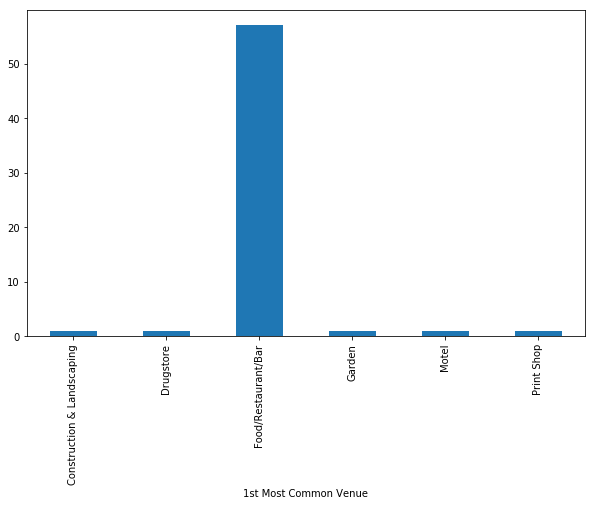

In [28]:
cluster1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0.0, toronto_merged.columns[[1,2,3,4] + list(range(5, toronto_merged.shape[1]))]]
cluster1_gp_1 = cluster1.groupby(["1st Most Common Venue"]).count()
cluster1_gp_2 = cluster1.groupby(["2nd Most Common Venue"]).count()
print("Mean Latitude, Longitude of cluster are: ", cluster1["Latitude"].mean(), ", " , cluster1["Longitude"].mean())
cluster1_gp_1["Neighborhood"].plot.bar(figsize=(10,6))

##### Cluster 1 - 1st most common venue's  is Food/Restaurant/Bar for most of the neighborhood.

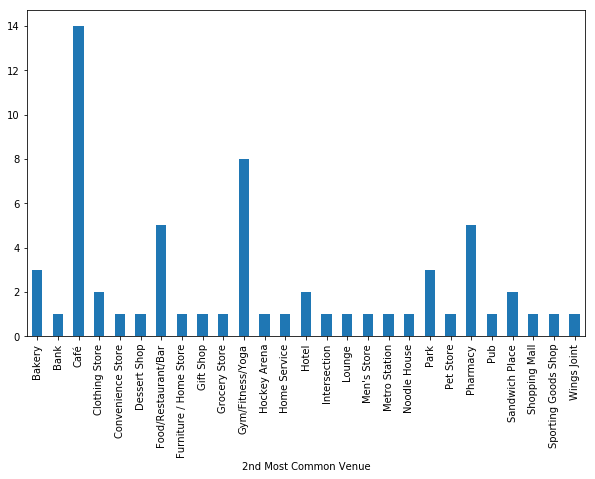

In [29]:
cluster1_gp_2["Neighborhood"].plot.bar(figsize=(10,6))

##### Cluster 1 - 2nd most common venue are Cafe, Gym/Fitness/Yoga & Pharmacy for most of the meihborhood.

### Cluster 2 neighborhoods

Mean Latitude, Longitude of cluster are:  43.702149102777774 ,  -79.41787311666666


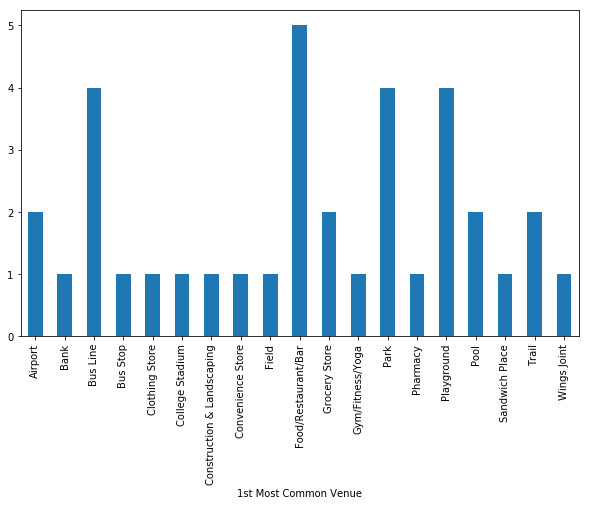

In [30]:
cluster2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1.0, toronto_merged.columns[[1,2,3,4] + list(range(5, toronto_merged.shape[1]))]]
cluster2_gp_1 = cluster2.groupby(["1st Most Common Venue"]).count()
cluster2_gp_2 = cluster2.groupby(["2nd Most Common Venue"]).count()
print("Mean Latitude, Longitude of cluster are: ", cluster2["Latitude"].mean(), ", " , cluster2["Longitude"].mean())
cluster2_gp_1["Neighborhood"].plot.bar(figsize=(10,6))

#### Cluster 2 - ist most common venue is Park, Playground & Bus Line in most of neighborhoods.

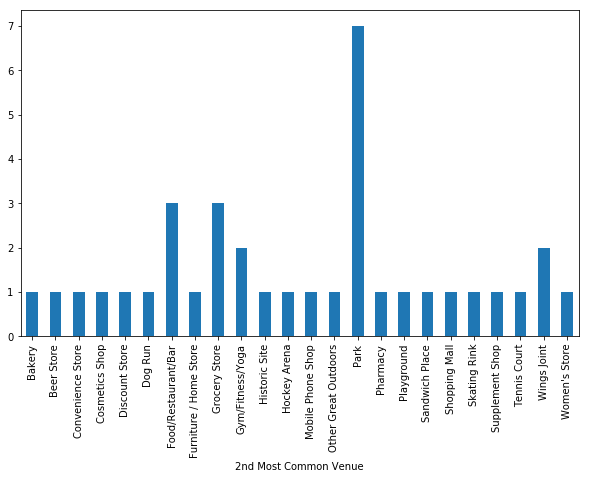

In [31]:
cluster2_gp_2["Neighborhood"].plot.bar(figsize=(10,6))

#### Cluster 2 - 2nd most common venue is Park in most of neighborhoods

### Cluster 3 neighborhood

Mean Latitude, Longitude of cluster are:  43.6805119 ,  -79.51537575


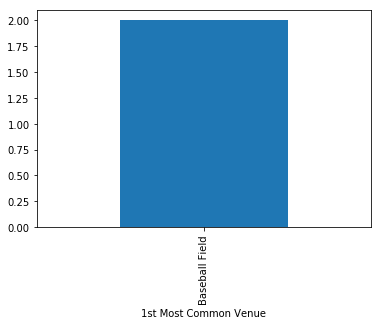

In [32]:
cluster3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2.0, toronto_merged.columns[[1,2,3,4] + list(range(5, toronto_merged.shape[1]))]]
cluster3_gp_1 = cluster3.groupby("1st Most Common Venue").count()
cluster3_gp_2 = cluster3.groupby("2nd Most Common Venue").count()
print("Mean Latitude, Longitude of cluster are: ", cluster3["Latitude"].mean(), ", " , cluster3["Longitude"].mean())
cluster3_gp_1["Neighborhood"].plot.bar()

#### Cluster 3 - 1st most common venue is baseball field in most of neighborhoods.

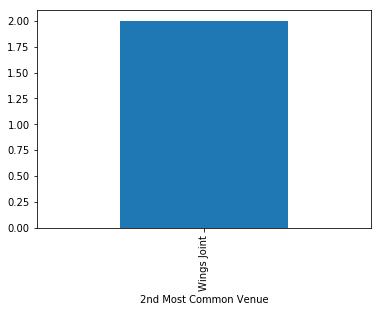

In [33]:
cluster3_gp_2["Neighborhood"].plot.bar()

#### Cluster 3 - 2nd most common venue is Wings Joint in most of neighborhoods.

## RESULT

In the 1st cluster we could see clearly throgh bar graph that Food/restaurant/Bar, Cafe & Gym/Fitness/Yoga are the popular venues. In 2nd cluster bar graph shows that Playground & Park are the popular venues. And similarly in 3rd cluster Baseball field and Wings joint are the most popular venues visited.

## DISCUSSION

As per by my analysis report following ecommendations can be made:<br>
1) Neighborhoods present in cluster 1 is apt choice for the business ventures looking for opening an an Restaurant/Bar. Also in few places Gym/Fitness centre can be a profitable as it appeared to be the 2nd most common venue in this cluster's neighborhood.<br>
2) Neighborhoods present in cluster 2 can be profitable for the business ventures that deals with park/playground maintaince stores. Because this neighborhood should maximum amount of visits due to Park or playground.<br>
3) Neighborhoods present in cluster 3 can be good for stores containing items related to baseball. As it is the most common venue being visited in that area.
    